In [ ]:
import numpy as np
import random
import itertools

class Node:
  def __init__(self, id, is_factor_node):
    '''
    1. create a node
    :param id: the node id (e.g. x1)
    :param is_factor_node: a boolean variable, true: is factor; false: is node
    :return:
    '''
    self.id = id
    self.is_factor_node = is_factor_node
    self.outgoing_edges = []
    self.incoming_edges = []

  def __hash__(self):
    return hash(self.id)

  def __eq__(self, other):
    return self.id == other.id

  def __str__(self):
    return self.id

In [ ]:
class Edge:
  def __init__(self, from_node, to_node):
    '''
    1. create a edge with direction(from_node -> to_node)
    2. each directed edge corresponds to one message(each iteration), it means the message sent by the 
    edge origin node to the edge end node; they are stored in list messgaes[]
    
    :param from_node: the origin node of this edge
    :param to_node: the end node of this edge  
    '''
    self.from_node = from_node
    self.to_node = to_node
    self.messages = []


  def __hash__(self):
    return hash(self.from_node + self.to_node)

  def __eq__(self, other):
    return (self.from_node, self.to_node) == (other.from_node, other.to_node)

  def __str__(self):
    return str(self.from_node) + "-->" + str(self.to_node)

In [ ]:
import re
class Graph:

  def __init__(self, H):
    '''
    1. create a graph according to parity-check matrix H
    2. store each edge in a dictionary (hashmap) with keys of the form "x1-->f3" for quick access
    3. store each node in a dictionary (node) with keys of the form "x1" for quick access
    :return:
    '''
    nodes = []
    self.graph_map = {}

    # create a dictonary according to H
    # the format of graph_map is like:
    # {"x1": ["f3"], 
    # "x2": ["f2"], 
    # "x3": ["f2", "f3"], 
    # "x4": ["f1"],
    # "x5": ["f1", "f3"],
    # "x6": ["f1", "f2"],
    # "x7": ["f1", "f2", "f3"],
    # "f1": ["x4", "x5", "x6", "x7"],
    # "f2": ["x2", "x3", "x6", "x7"],
    # "f3": ["x1", "x3", "x5", "x7"]}
    dim_0 = H.shape[0]
    dim_1 = H.shape[1]

    for i in range(dim_1):
      nodes.append('x{}'.format(i + 1))
    for i in range(dim_0):
      nodes.append('f{}'.format(i + 1))
    for node in nodes:
      self.graph_map[node] = []
      i = int(''.join(re.findall('[1-7]', node))) - 1

      if ''.join(re.findall('[a-z]', node)) == 'x':
        for j in range(dim_0):
          if H[j,i] == 1:
            self.graph_map[node].append('f{}'.format(j + 1))

      elif ''.join(re.findall('[a-z]', node)) == 'f':
        for j in range(dim_1):
          if H[i,j] == 1:
            self.graph_map[node].append('x{}'.format(j + 1))


    for key in self.graph_map:
      val = self.graph_map[key]
                             
    # create the graph
    self.nodes = {}
    self.edges = {}
    for node, _ in self.graph_map.items():
      n = None
      if node.startswith("x"):
        n = Node(node, False)
      elif node.startswith("f"):
        n = Node(node, True)
      self.nodes[n.id] = n
    for node, connections in self.graph_map.items():
      n = self.nodes[node]
      for connection in connections:
        edge = None
        if self.nodes.get(connection):
          edge = Edge(n, self.nodes[connection])
        n.outgoing_edges.append(edge)
        self.nodes[connection].incoming_edges.append(edge)
        self.edges[str(edge)] = edge

  def __str__(self):
    result = ""
    for id, node in self.nodes.items():
      result += str(node) + " (" + str(node.is_factor_node) + ") :\n"
      for edge in node.outgoing_edges:
        result += str(edge) + "\n"
      result += "\n"
    return result

In [ ]:
class Codeword:
  '''
  create a codeword
  '''

  def __init__(self, variance, H):
    '''
    initialize a codeword object with a randomly selected codeword.
    '''
    self.variance = variance
    self.H = H
    self.codeword = Codeword.random_select_codeword()
    self.transmission = Codeword.encode_noise(self)

  def encode_noise(self):
    '''
    1. codeword x --> y:{x=0 --> y=1; x=1 --> y=-1} --> + Gussian noise(0, variance) --> z
    :param variance: the variance of the Gaussian noise
    :return: z (an array)
    '''
    def y(x):
      if x == 1:
        return -1
      elif x == 0:
        return 1

    z = list(map(y, self.codeword)) + np.random.normal(0, self.variance, len(self.codeword))
    
    return [self.codeword, z]

  @classmethod
  def random_select_codeword(cls):
    """
    1. randomly select one codeword from 16 possible codewords.
    :return: one codeword (a list)
    """
    return random.choice(Codeword.generate_codewords())
    # return list(random.choice(cls.codeword_list))

  @classmethod
  def generate_codewords(cls):
    """
    1. generate all valid codewords using parity-check matrix H
    :return: all valid codewords, type: list, length: 16
    """
    all_x = np.matrix(list(itertools.product(range(2), repeat = 7)))
    all_codewords = []
    for x in all_x:
      prod = x * np.transpose(H) % 2
      if np.count_nonzero(prod) == 0:
        all_codewords.append(x.tolist()[0])

    return all_codewords

In [ ]:
def prior_x(z, variance):
  '''
  calculate p(x|z) for any x_i and observed z_i
  :param z: the observed value
  :param sigma: the variance of Gaussian noise
  :return: [p(x=0|z), p(x=1|z)]
  '''
  p0 = 1 / (1 + np.exp(-2 * float(z) / variance))
  p1 = 1 / (1 + np.exp(2 * float(z) / variance))
  return [p0, p1]

In [ ]:
def calculate_message(graph, from_node, to_node, i):
  '''
  1. calculate the message sent by from_node to to_node
  2. if from_node is a node, calculate the product of all incoming messages except: to_node -> from_node
  3. if from_node is a factor, calculate the sum of factor_i * all incoming messages except: to_node -> from_node
  :param i: corresponds to the iteration, also the length of messages of each edge
  :return: the new graph, its message of edge(from_node->to_node) is added a new one/ updated
  '''

  if can_calculate(from_node, to_node, i):
    incoming_messages = []
    for edge in from_node.incoming_edges:
      if edge.from_node.id != to_node.id: # all incoming edges except to_node -> from_node
        incoming_messages.append(edge.messages[i]) # store the messages of these edges
        # print("edge.messages:",edge.messages)
        # print("incoming_messages.messages:",incoming_messages)
    if from_node.is_factor_node: # if it's factor node
      # calculate the message(from_node->to_node)
      message = [Message_f_to_x(incoming_messages, 0), Message_f_to_x(incoming_messages, 1)]
    elif not from_node.is_factor_node: # if it's variable node
      message = [Message_x_to_f(incoming_messages, 0), Message_x_to_f(incoming_messages, 1)]

    # store this new message in the graph
    edge_id = from_node.id + "-->" + to_node.id
    # if graph.edges[edge_id].messages[0] == None:
    #   graph.edges[edge_id].messages[0] = message
    # else:
    graph.edges[edge_id].messages.append(message)
  
  else:
    edge_id = from_node.id + "-->" + to_node.id
    msg = graph.edges[edge_id].messages[i]
    graph.edges[edge_id].messages.append(msg)
  return graph


def can_calculate(from_node, to_node, i):
  '''
  check whether the message in such path can be calculated
  '''
  for edge in from_node.incoming_edges:
    if edge.from_node.id != to_node.id and edge.messages[i] == None:
      return False
  return True


def Message_f_to_x(incoming_messages, to_node_value):
  '''
  1. calculate the message from a factor to a x node
  2. each factor connects 4 x nodes, three of them are summed
  '''
  sum = 0
  
  configs = list(itertools.product([0, 1], repeat= 3))#configs=[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
  for i in range(len(configs)):
    xi = configs[i][0]
    xj = configs[i][1]
    xk = configs[i][2]
    sum += factor_i(xi, xj, xk, to_node_value) * incoming_messages[0][xi] * incoming_messages[1][xj] * incoming_messages[2][xk]
    # print("i=",i,"sum=",sum)
  return sum


def factor_i(xi, xj, xm, xn):
  '''
  1. the function of each factor
  2. if it satisfy each equation, return 1; otherwise, returen 0
  '''
  if (xi + xj + xm + xn) % 2 == 0:
    return 1
  else:
    return 0


def Message_x_to_f(incoming_messages, to_node_value):
  '''
  calculate the message from a x node to a factor 
  :return: the product of all incoming messages
  '''
  prod = 1

  for i in range(len(incoming_messages)):
    prod *= incoming_messages[i][to_node_value]
  return prod
   

In [ ]:
def calculate_belief(graph):
  """
  1. calculate the belief for each node x_i
  2. then calculate which value (0 or 1) of x_i can make its belief to be maximum
  3. then get a list of the values of x_1 to x_7
  """
  results = []
  for i in range(1, 8):
    belief = [1.0, 1.0]
    # the current node x_i(i=1,...,8)
    node = graph.nodes["x" + str(i)]
    for edge in node.incoming_edges: # all incoming messages
      message = edge.messages[-1] # the latest message
      # node = 0
      belief[0] *= message[0]
      # node = 1
      belief[1] *= message[1]
      
    '''
    if belief[0] > belief[1], then x_i should be 0,
    vice versa
    '''
    if belief[0] >= belief[1]:
      results.append(0)
    else:
      results.append(1)
  return results

In [ ]:
def initialize(H, variance):
  # SIGMA = 0.5
  # H = np.matrix([[0, 0, 0, 1, 1, 1, 1], [0, 1, 1, 0, 0, 1, 1], [1, 0, 1, 0, 1, 0, 1]])
  # create a codeword z and the corresponding code x
  codeword = Codeword(variance, H)
  x, z = codeword.encode_noise()
  print("Encoding:")
  print("x=",x)
  print("z=",z)
  '''
  create a graph and initialize it:
  1. initialize the messages of each edge(direction: from x to f)
  2. for the edge from a factor to a x node: the message is set to be None
  3. for the edge from a x node to a factor: the message is set to be the prior probability p(x|z), the 
  format is [p(x=0|z), p(x=1|z)]
  '''
  graph = Graph(H)
  for id, node in graph.nodes.items():
    # if it's a node
    if not node.is_factor_node: 
      for edge in node.outgoing_edges:
        node_num = int(list(id)[1])
        edge.messages.append(prior_x(z[node_num - 1], variance))
    # if it's a factor
    else: 
      for edge in node.outgoing_edges:
        edge.messages.append(None)
  return graph, x, z

In [ ]:
def decoding(H, variance, M = 10000, ITERATION = 20):
  # dB
  n = H.shape[1]
  k = H.shape[1] - H.shape[0]
  E_s = 1
  E_b = E_s * n / k
  N_0 = 2 * variance
  dB = E_b / N_0
  '''
  decode M times to get Pe
  '''  

  sum_mi = 0
  for m in range(M):
    # if m % 1000 == 0: print("m=",m," in M=", M)
    # sum_mi = 0
    decoded = []
    codeword = Codeword(variance, H)
    all_codewords = codeword.generate_codewords()
    graph, x, z = initialize(H, variance)
    '''
    decode z:
    1: iterate the messages passing for 20 times
    2: for each iteration:
      1) using function calculate_message:
        calculate the message sent by each node to its all neighbors
        calculate the message sent by (x->f) first, then by (f->x)
      2) using function calculate_belief: 
        in this new graph(each edge with a list of messages), calculate the beliefs,
        and choose one sequence of x_1 to x_7 that has max belief
      3) check whether this sequence is one of all possible codewords:
        if so, stop iterating, output this result
        otherwise, continue to iteratation
    '''
    for i in range(ITERATION):
      # get all nodes in the graph
      for id, node in graph.nodes.items():
        for edge in node.outgoing_edges:
          graph = calculate_message(graph, node, edge.to_node, i)


      decoded = calculate_belief(graph)
      if decoded in all_codewords:
        # sum_mi: the number of incorrect bits
        for i in range(n):
          if decoded[i] != x[i]:
            sum_mi += 1
        print("Decoding:")
        print("x=", decoded)
        break
      else:
        print("didn't find x, continue to iterating.")
  Pe = sum_mi / (n * M)
  return dB, Pe

In [ ]:
H = np.matrix([[0, 0, 0, 1, 1, 1, 1], [0, 1, 1, 0, 0, 1, 1], [1, 0, 1, 0, 1, 0, 1]])
print("variance = 1/8:")
_, _ = decoding(H, variance = 1/8, M = 1)
print("variance = 1/4:")
_, _ = decoding(H, variance = 1/4, M = 1)
print("variance = 1/2:")
_, _ = decoding(H, variance = 1/2, M = 1)
print("variance = 1:")
_, _ = decoding(H, variance = 1, M = 1)
print("variance = 2:")
_, _ = decoding(H, variance = 2, M = 1)


variance = 1/8:
Encoding:
x= [0, 1, 1, 1, 1, 0, 0]
z= [ 0.91463643 -1.04828693 -0.88629405 -1.03800964 -0.79334299  0.99468567
  1.1519509 ]
Decoding:
x= [0, 1, 1, 1, 1, 0, 0]
variance = 1/4:
Encoding:
x= [0, 0, 0, 0, 0, 0, 0]
z= [0.893636   1.07573153 0.86215208 1.40195153 1.09457225 0.52076762
 1.15601441]
Decoding:
x= [0, 0, 0, 0, 0, 0, 0]
variance = 1/2:
Encoding:
x= [1, 1, 0, 1, 0, 0, 1]
z= [-1.40581606 -0.88228942  1.50295229 -2.32115364  1.36225529  1.60875751
 -1.11034783]
Decoding:
x= [1, 1, 0, 1, 0, 0, 1]
variance = 1:
Encoding:
x= [1, 0, 0, 0, 0, 1, 1]
z= [-1.76771459  0.94202032  1.22386999  0.39407032  0.86429522 -1.41616399
 -0.88089632]
Decoding:
x= [1, 0, 0, 0, 0, 1, 1]
variance = 2:
Encoding:
x= [1, 0, 0, 0, 0, 1, 1]
z= [-2.59663974  1.56055666 -0.2130228   1.13405952 -1.02442117 -3.0603793
 -0.67898965]
didn't find x, continue to iterating.
didn't find x, continue to iterating.
didn't find x, continue to iterating.
Decoding:
x= [0, 0, 0, 0, 0, 0, 0]


In [ ]:
H = np.matrix([[0, 0, 0, 1, 1, 1, 1], [0, 1, 1, 0, 0, 1, 1], [1, 0, 1, 0, 1, 0, 1]])
dB = []
Pe = []

db, pe = decoding(H, variance = 1/8, M = 10000)
print("variance = 1/8", " dB=", db, " Pe=", pe)
dB += [db]
Pe += [pe]

db, pe = decoding(H, variance = 1/4, M = 10000)
print("variance = 1/4", " dB=", db, " Pe=", pe)
dB += [db]
Pe += [pe]

db, pe = decoding(H, variance = 1/2, M = 10000)
print("variance = 1/2", " dB=", db, " Pe=", pe)
dB += [db]
Pe += [pe]

db, pe = decoding(H, variance = 1, M = 10000)
print("variance = 1", " dB=", db, " Pe=", pe)
dB += [db]
Pe += [pe]

db, pe = decoding(H, variance = 2, M = 10000)
print("variance = 2", " dB=", db, " Pe=", pe)
dB += [db]
Pe += [pe]


variance = 1/8  dB= 7.0  Pe= 0.0
variance = 1/4  dB= 3.5  Pe= 4.2857142857142856e-05
variance = 1/2  dB= 1.75  Pe= 0.046657142857142855
variance = 1  dB= 0.875  Pe= 0.2922
variance = 2  dB= 0.4375  Pe= 0.4310428571428571


In [ ]:
import math
for i in range(len(dB)):
  dB[i] = math.log(dB[i])
print(dB)

[1.9459101490553132, 1.252762968495368, 0.5596157879354227, -0.13353139262452263, -0.8266785731844679]


No handles with labels found to put in legend.


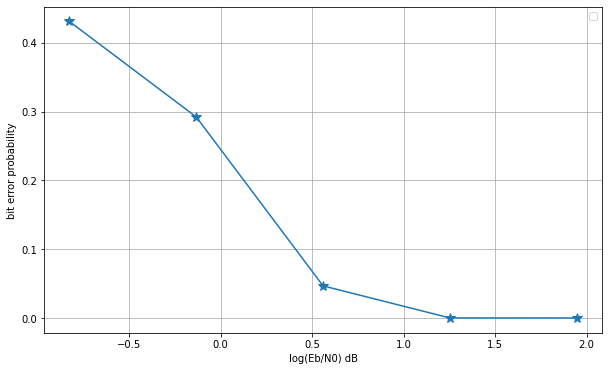

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 6))


plt.plot(dB, Pe, marker='*', ms=10)
plt.xlabel("log(Eb/N0) dB")
plt.ylabel("bit error probability")
plt.legend()
plt.grid()

In [ ]:
import math
dB2 = []
Pe2 = []

db, pe = decoding(H, variance = 1/8, M = 100000)
print("variance = 1/8", " dB=", db, " Pe=", pe)
dB2 += [math.log(db)]
Pe2 += [pe]

db, pe = decoding(H, variance = 1/4, M = 100000)
print("variance = 1/4", " dB=", db, " Pe=", pe)
dB2 += [math.log(db)]
Pe2 += [pe]

db, pe = decoding(H, variance = 1/2, M = 100000)
print("variance = 1/2", " dB=", db, " Pe=", pe)
dB2 += [math.log(db)]
Pe2 += [pe]

db, pe = decoding(H, variance = 1, M = 100000)
print("variance = 1", " dB=", db, " Pe=", pe)
dB2 += [math.log(db)]
Pe2 += [pe]

db, pe = decoding(H, variance = 2, M = 100000)
print("variance = 2", " dB=", db, " Pe=", pe)
dB2 += [math.log(db)]
Pe2 += [pe]

variance = 1/8  dB= 7.0  Pe= 0.0
variance = 1/4  dB= 3.5  Pe= 7.857142857142857e-05
variance = 1/2  dB= 1.75  Pe= 0.047945714285714286
variance = 1  dB= 0.875  Pe= 0.29650714285714286
variance = 2  dB= 0.4375  Pe= 0.4370742857142857


No handles with labels found to put in legend.


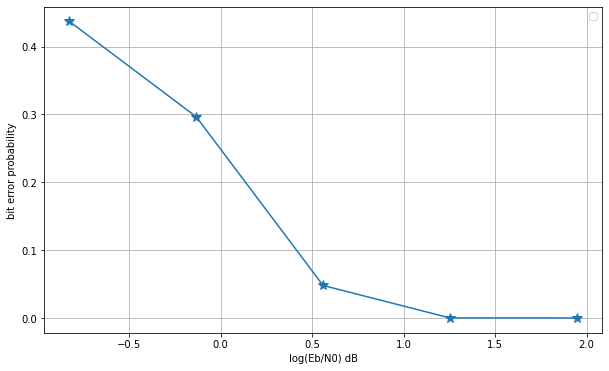

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 6))


plt.plot(dB2, Pe2, marker='*', ms=10)
plt.xlabel("log(Eb/N0) dB")
plt.ylabel("bit error probability")
plt.legend()
plt.grid()